In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')

import sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

In /home/piyush/.conda/envs/kaggle/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/piyush/.conda/envs/kaggle/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/piyush/.conda/envs/kaggle/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/piyush/.conda/envs/kaggle/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/piyush/.conda/e

In [2]:
data_dir = "../data/news/"
data_true = pd.read_csv(data_dir + "True.csv")
data_fake = pd.read_csv(data_dir + "Fake.csv")

In [3]:
data_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
data_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
data_true.shape, data_fake.shape  # Balanced

((21417, 4), (23481, 4))

In [6]:
data_true['class'] = 1
data_fake['class'] = 0

data = pd.concat([data_true, data_fake])

In [7]:
data['subject'].unique()

array(['politicsNews', 'worldnews', 'News', 'politics', 'Government News',
       'left-news', 'US_News', 'Middle-east'], dtype=object)

#### Classification can be directly done based on the subject tag itself.  
worldnews and politicsNews tags are exclusive to true news and other subject tags are exclusive to fake news.

<AxesSubplot:xlabel='subject'>

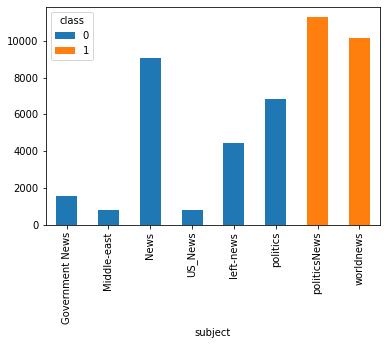

In [8]:
df_plot = data.groupby(['class', 'subject']).size().reset_index().pivot(columns='class', index='subject', values=0)
df_plot.plot(kind='bar', stacked=True)  # was looking for stacked representation

In [9]:
data[(data['subject']=='worldnews') | (data['subject']=='politicsNews')].__len__()

21417

In [10]:
data_true['subject'].unique()

array(['politicsNews', 'worldnews'], dtype=object)

In [11]:
data_fake['subject'].unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

#### Anyway, ignoring subject tag

In [12]:
# Combining text and heading
data['text'] = data['title'] + ' ' + data['text']
data.drop(['subject', 'title', 'date'], axis=1, inplace=True)

# Preprocessing
def cleaner(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

data['text'] = data['text'].apply(lambda x:cleaner(x))

stopwords_eng = stopwords.words('english')
data['text'] = data['text'].apply(
    lambda x: ' '.join([w for w in x.split() if w not in (stopwords_eng)]))

def lemmatize(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmatized = ' '.join([lemmatizer.lemmatize(w) for w in text.split()])    
    return lemmatized

data['text'] = data['text'].apply(lemmatize)

data.head()

,text,class
0,u budget fight loom republican flip fiscal scr...,1
1,u military accept transgender recruit monday p...,1
2,senior u republican senator let mr mueller job...,1
3,fbi russia probe helped australian diplomat ti...,1
4,trump want postal service charge much amazon s...,1


In [13]:
# train-test split
mask = np.random.rand(len(data)) < 0.8
train = data[mask]['text']
test = data[~mask]['text']
y_train = data[mask]['class']
y_test = data[~mask]['class']

train.shape, test.shape

((35959,), (8939,))

In [15]:
vectorizer = CountVectorizer()
vectors_train = vectorizer.fit_transform(train.values)
vectors_test = vectorizer.transform(test.values)

vectorizer.vocabulary_.__len__(), vectors_train.shape

(173845, (35959, 173845))

In [17]:
classifier = MultinomialNB()
classifier.fit(vectors_train, y_train)

pred_train = classifier.predict(vectors_train)
print(classification_report(y_train, pred_train))  # 0-fake 1-true

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     18820
           1       0.96      0.97      0.97     17139

    accuracy                           0.97     35959
   macro avg       0.97      0.97      0.97     35959
weighted avg       0.97      0.97      0.97     35959



In [19]:
pred_test = classifier.predict(vectors_test)
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      4661
           1       0.95      0.96      0.96      4278

    accuracy                           0.96      8939
   macro avg       0.96      0.96      0.96      8939
weighted avg       0.96      0.96      0.96      8939

